In [1]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')


In [3]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [4]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [5]:
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)


In [6]:
svd.fit(trainset)

In [7]:
predictions = svd.test(testset)

In [8]:
# 5. Evaluate the Model
# Calculate and print the RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")

# Calculate and print the MAE
mae = accuracy.mae(predictions)
print(f"MAE: {mae}")

RMSE: 0.7750
RMSE: 0.7750358404404342
MAE:  0.5825
MAE: 0.582516094673271


In [9]:
# Generate Recommendations
# Function to get top-N recommendations for a user
def get_top_n_recommendations(model, user_id, n=10):
    # Get a list of all movie IDs
    all_movie_ids = movies['movieId'].unique()
    
    # Predict ratings for all movies this user hasn't rated yet
    user_ratings = ratings[ratings['userId'] == user_id]['movieId']
    movies_to_predict = list(set(all_movie_ids) - set(user_ratings))
    
    # Make predictions
    predictions = [model.predict(user_id, movie_id) for movie_id in movies_to_predict]
    
    # Sort predictions by estimated rating
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Get movie titles
    top_n_titles = [(movies[movies['movieId'] == pred.iid]['title'].iloc[0], pred.est) for pred in top_n]
    
    return top_n_titles

In [10]:
user_id = 1
recommendations = get_top_n_recommendations(svd, user_id)

print(f"Top 10 recommendations for user {user_id}:")
for title, est in recommendations:
    print(f"{title}: Estimated rating = {est:.2f}")

Top 10 recommendations for user 1:
Alien (1979): Estimated rating = 4.87
Night of the Living Dead (1968): Estimated rating = 4.75
Under the Skin (2013): Estimated rating = 4.64
Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972): Estimated rating = 4.59
Deep End (1970): Estimated rating = 4.58
A Silent Voice (2016): Estimated rating = 4.54
Fitzcarraldo (1982): Estimated rating = 4.53
Halloween (1978): Estimated rating = 4.52
Thing, The (1982): Estimated rating = 4.51
Terminator 2: Judgment Day (1991): Estimated rating = 4.47


## An example to analyze our recommendation system

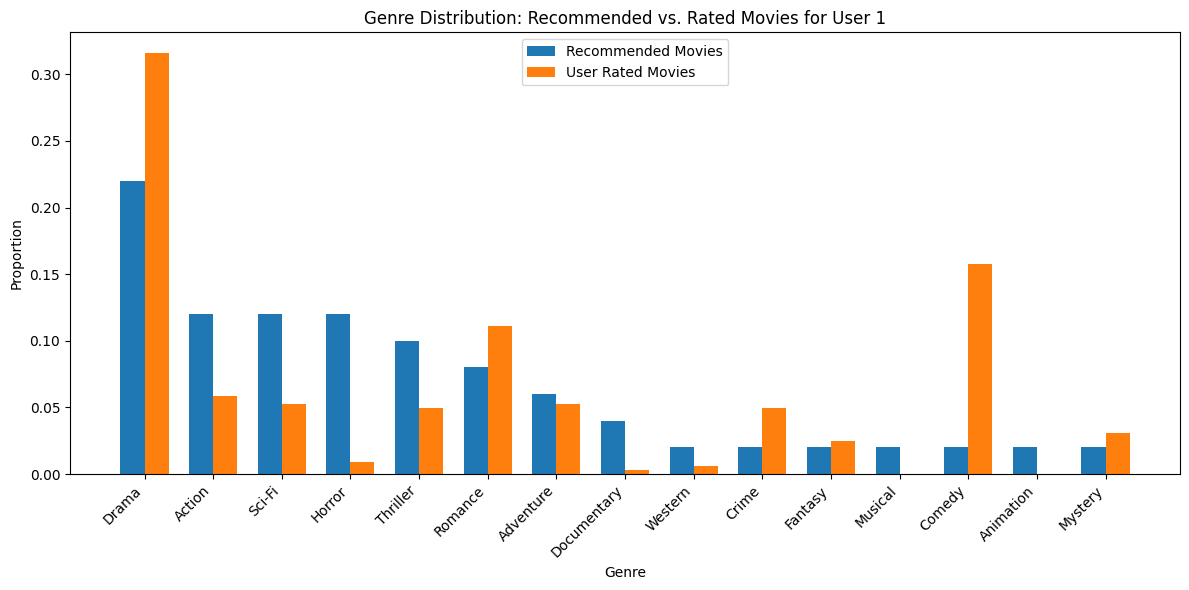

In [11]:
def get_genre_distribution(movie_ids):
    genre_list = movies[movies['movieId'].isin(movie_ids)]['genres'].str.split('|', expand=True).stack()
    return genre_list.value_counts(normalize=True)

# Get recommendations for a sample user
sample_user = 1
recommendations = get_top_n_recommendations(svd, sample_user, n=20)
recommended_movie_ids = [movies[movies['title'] == rec[0]]['movieId'].iloc[0] for rec in recommendations]

# Get genre distribution of recommended movies
rec_genre_dist = get_genre_distribution(recommended_movie_ids)

# Get genre distribution of all movies the user has rated
user_rated_movies = ratings[ratings['userId'] == sample_user]['movieId']
user_genre_dist = get_genre_distribution(user_rated_movies)

# Plot comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(rec_genre_dist))

plt.bar(index, rec_genre_dist, bar_width, label='Recommended Movies')
plt.bar(index + bar_width, user_genre_dist.reindex(rec_genre_dist.index), bar_width, label='User Rated Movies')

plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.title(f'Genre Distribution: Recommended vs. Rated Movies for User {sample_user}')
plt.xticks(index + bar_width/2, rec_genre_dist.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()